# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


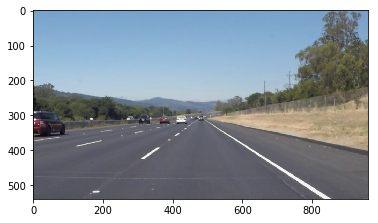

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [6]:
def readAndPlotImage(path, cmap=None):
    #reading in an image
    image = mpimg.imread(path)

    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image, cmap=cmap)  
    plt.show()

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


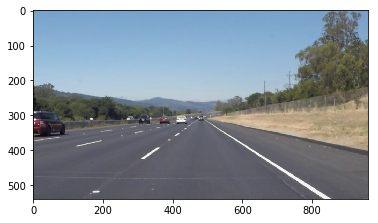

In [7]:
readAndPlotImage('test_images/solidWhiteRight.jpg')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [877]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices, invert=False):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are zero
    if invert:
        masked_image = cv2.bitwise_and(img, cv2.bitwise_not(mask))
        
    #returning the image only where mask pixels are nonzero
    else:
        masked_image = cv2.bitwise_and(img, mask)

    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [878]:
def hough_output(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

In [ ]:

    mask_inner = np.array([[480, 335], [480, 335], [700, image.shape[0]], [300, image.shape[0]]], 'int32')

In [1345]:
def get_mask(img, inner=False):
    dim = img.shape
    if inner:
        x = np.array([480., 480., 690., 290.])/960.*dim[1]
        y = np.array([340., 340., 500., 500.])/540.*dim[0]
        
    else:
        x = np.array([400., 550., 900., 120.])/960.*dim[1]
        y = np.array([335., 335., 500., 500.])/540.*dim[0]
    
    mask = np.array([[x[0], y[0]], [x[1], y[1]], [x[2], y[2]], [x[3], y[3]]], 'int32')
    return mask


def draw_lines_final(img, lines, color=[255, 0, 0], thickness=2, style='split'):
    """
    Take in set of line segments (output of extrapolate_lines). 
    Draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    
    The input has 3 line segments: 
        - avg line: should run through center of the lane line
        - top line: approximates location of the top lane line
        - bot line: approximates location of the bottom lane line
        
    style parameter:
      split:
          draw each line in a different color (red, green, blue)
      avg:
          only draw the avg line (in specified color)
      fill:
          polyfill between the top/bottom lines (in specified color)
    """
    if style=='split':
        for i, line in enumerate(lines):
            for x1,y1,x2,y2 in line:
                color = [0, 0, 0]
                color[i] = 255
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
    elif style=='avg':
        if lines.shape[0] > 0:
            for x1,y1,x2,y2 in lines[0]:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness*5)
            
    elif style=='fill':
        if lines.shape[0] > 0:
            for x1,y1,x2,y2 in lines[0]:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def describe_lines(lines):
    slope = []
    l = []
    interc1 = []
    interc2 = []

    for i, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            slope += [np.round(m*180/np.pi, 0)]
            l += [np.sqrt((y2-y1)**2 + (x2-x1)**2)]
            # x intercept at bottom of image (y=540)
            interc1 += [np.round((540-y1)/m + x1, 0)]
            # x intercept at top of image (y=310)
            interc2 += [np.round((310-y1)/m + x1, 0)]

    df_lines = pd.DataFrame({'slope': slope, 'weight': l, 'int_bot': interc1, 'int_top': interc2,
                             'x1': lines[:, :, 0].flatten(),
                             'y1': lines[:, :, 1].flatten(),
                             'x2': lines[:, :, 2].flatten(),
                             'y2': lines[:, :, 3].flatten(),})
    return df_lines


def filter_lines(df_lines, min_bot=0, max_bot=960, min_top=100, max_top=800):
    # print('filter: ', (min_bot, max_bot, min_top, max_top))
    candidates = df_lines[(df_lines.int_bot > min_bot) & (df_lines.int_bot < max_bot) &
                          (df_lines.int_top > min_top) & (df_lines.int_top < max_top)]\
        .sort_values('x1').reset_index(drop=True)
    return candidates


def line_coord(df_lines):
    return df_lines[['x1', 'y1', 'x2', 'y2']].values.reshape(-1, 1, 4)

            
def hough_lines2(img, rho, theta, threshold, min_line_len, max_line_gap, style='avg', color=[255, 0, 0], extrapolate=True):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # get slope and extrapolated intercepts of each line segment
    df_lines = describe_lines(lines)
    # filter for lines that roughly fit within the mask 
    # (NOTE: this will also exclude any roughly horizontal lines!!!)
    df_filt = filter_lines(df_lines, max_bot=img.shape[1], min_top=0.1*img.shape[1], max_top=0.8*img.shape[1])
    
    left_raw = line_coord(df_filt[df_filt.slope < 0])
    right_raw = line_coord(df_filt[df_filt.slope >= 0])
    
    # split line segments into two halves: negative slope and positive slope
    if extrapolate:
        left_lines = extrapolate_lines(img, left_raw, style=style)
        right_lines = extrapolate_lines(img, right_raw, style=style)
    else:
        left_lines = left_raw
        right_lines = right_raw
    
    # draw the lines on a blank image:
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_final(line_img, left_lines, style=style, color=color)
    draw_lines_final(line_img, right_lines, style=style, color=color)

    return line_img, left_raw, right_raw

In [1346]:
from sklearn import linear_model

def extrapolate_lines(img, lines, style='avg'):
    if lines.shape[0] < 1:
        return np.array([])
    
    mask = get_mask(img)
    
    # extract and plot lines onto blank image
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, color=[255, 0, 0], thickness=1)
    
#     plt.imshow(line_img);
#     plt.ylim([540, 300]); plt.xlim([200,850]);
#     plt.show()

    # grab the red x and y coordinates (the location of all line pixels)
    y_raw, x_raw, _ = np.where(line_img>200)
    y_raw = y_raw.reshape(-1, 1)
    x_raw = x_raw.reshape(-1, 1)
    
    # fit a linear regression to all pixels
    # lm = linear_model.LinearRegression()
    lm = linear_model.HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,
                           epsilon=1.5)
    lm_avg = lm.fit(y_raw, x_raw)
    y_line = np.array([[mask[0, 1]], [mask[-1, 1]]])
    x_lineAVG = lm_avg.predict(y_line).astype(int)

    if style == 'avg':
        return np.array([[[x_lineAVG[0], y_line[0], x_lineAVG[1], y_line[1]]]])
        
    else:
        # compare raw points to the predicted values - split into 2 groups:
        #    pixels above or below the regression line
        x_pred = lm_avg.predict(y_raw).reshape(-1, 1)
        x_top = np.extract(x_raw >= x_pred, x_raw).reshape(-1, 1)
        y_top = np.extract(x_raw >= x_pred, y_raw).reshape(-1, 1)
        x_bot = np.extract(x_raw < x_pred, x_raw).reshape(-1, 1)
        y_bot = np.extract(x_raw < x_pred, y_raw).reshape(-1, 1)

        # fit a separate regression to the top pixels
        lm_top = lm.fit(y_top, x_top)
        x_lineTOP = lm_top.predict(y_line).astype(int)

        # fit a separate regression to the bottom pixels
        lm_bot = lm.fit(y_bot, x_bot)
        x_lineBOT = lm_bot.predict(y_line).astype(int)

        extrapolated_lines = np.array([
            [[x_lineAVG[0], y_line[0], x_lineAVG[1], y_line[1]]],
            [[x_lineTOP[0], y_line[0], x_lineTOP[1], y_line[1]]],
            [[x_lineBOT[0], y_line[0], x_lineBOT[1], y_line[1]]],
        ])
    
        return extrapolated_lines

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [745]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


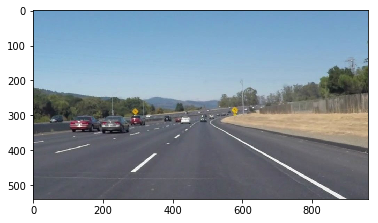

solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


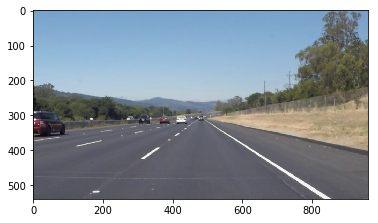

solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


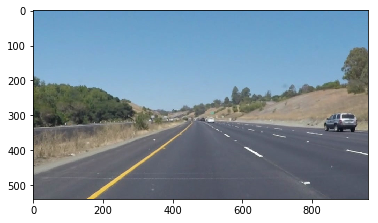

solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


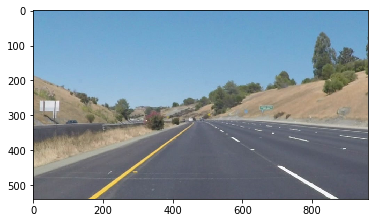

solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


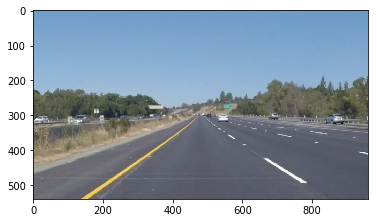

whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


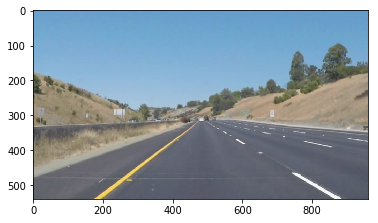

In [8]:
for f in os.listdir("test_images/"):
    print(f)
    readAndPlotImage('test_images/%s' % f)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

#### Step 1: Find a polygon mask I like

In [22]:
def testMask(path, mask):
    image = mpimg.imread(path)
    masked_image = region_of_interest(image, [mask])
    plt.imshow(masked_image)
    plt.show()

solidWhiteCurve.jpg


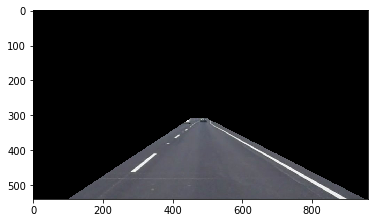

solidWhiteRight.jpg


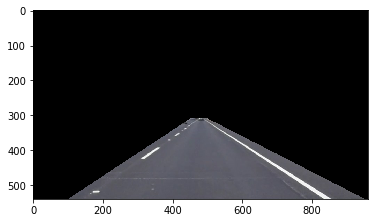

solidYellowCurve.jpg


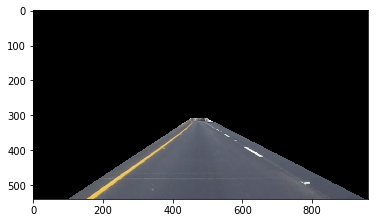

solidYellowCurve2.jpg


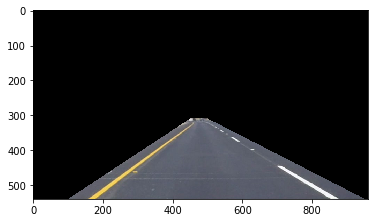

solidYellowLeft.jpg


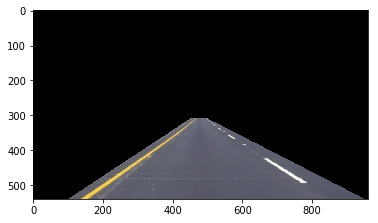

whiteCarLaneSwitch.jpg


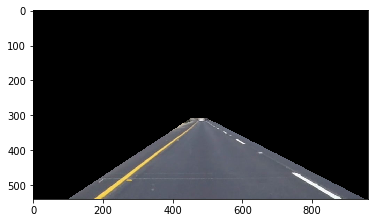

In [35]:
mask = np.array([[450, 310], [500, 310], [950, image.shape[0]], [100, image.shape[0]]], 'int32')
for f in os.listdir("test_images/"):
    print(f)
    testMask('test_images/%s' % f, mask)

#### Step 2: Detect Line Segments

In [283]:
def testLineSegments(path, mask):
    # First get the image
    image = mpimg.imread(path)
    
    # convert to grayscale and get canny edges
    gray_img = grayscale(image)
    canny_img = canny(gray_img, 10, 200)
    
    # next mask the image
    mask = np.array([[450, 325], [525, 325], [950, image.shape[0]], [100, image.shape[0]]], 'int32')
    masked_img = region_of_interest(canny_img, [mask])
    
    # gaussian blur:
    smooth_img = gaussian_blur(masked_img, 3)
    
    # detect line segments:
    line_seg = hough_lines(smooth_img, 2, 15*np.pi/180, 25, 15, 10)
    
    result = weighted_img(line_seg, image)
    
    plt.figure(figsize=(10,5))
    plt.imshow(line_seg)
#     plt.figure(figsize=(18,5))
#     plt.subplot(1, 3, 1)
#     plt.imshow(result)
#     plt.subplot(1, 3, 2)
#     plt.imshow(smooth_img)
#     plt.subplot(1, 3, 3)
#     plt.imshow(region_of_interest(gray_img, [mask]), cmap='gray')
    plt.ylim([540, 300])
    plt.show()

solidWhiteCurve.jpg


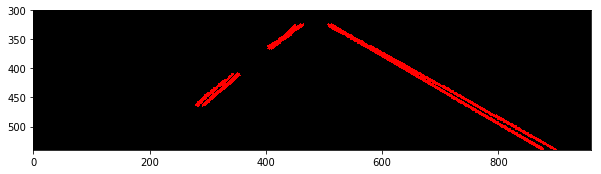

solidWhiteRight.jpg


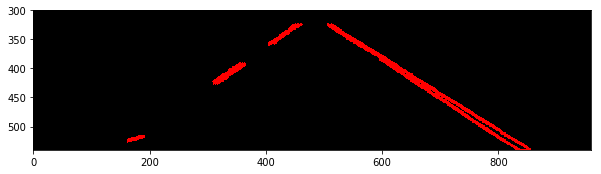

solidYellowCurve.jpg


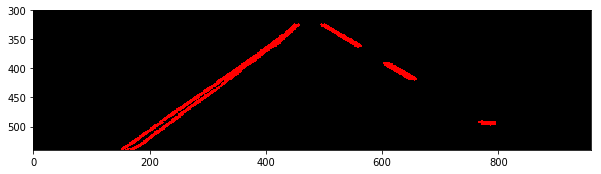

solidYellowCurve2.jpg


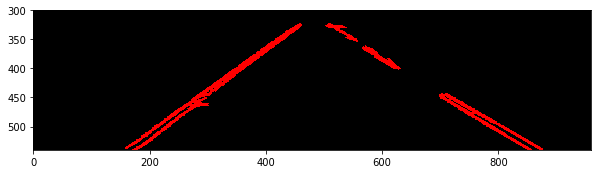

solidYellowLeft.jpg


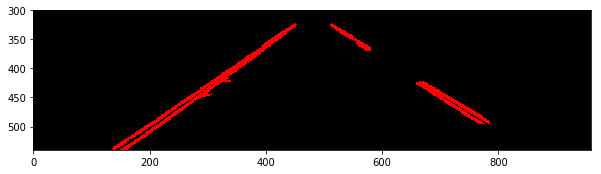

whiteCarLaneSwitch.jpg


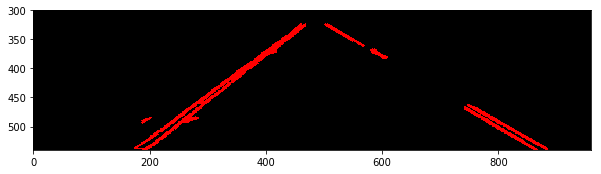

In [284]:
for f in os.listdir("test_images/"):
    print(f)
    testLineSegments('test_images/%s' % f, mask)

In [362]:
def testLineSegments2(path, mask):
    # First get the image
    image = mpimg.imread(path)
    
    # convert to grayscale and get canny edges
    gray_img = grayscale(image)
    canny_img = canny(gray_img, 10, 200)
    
    # next mask the image
    mask = np.array([[450, 325], [525, 325], [950, image.shape[0]], [100, image.shape[0]]], 'int32')
    masked_img = region_of_interest(canny_img, [mask])
    
    # gaussian blur:
    smooth_img = gaussian_blur(masked_img, 3)
    
    # detect line segments:
    line_seg = hough_lines(smooth_img, 2, 15*np.pi/180, 25, 15, 10)
    
    # gaussian blur:
    smooth_img2 = gaussian_blur(line_seg, 5)
    
    # detect line segments:
#     canny_img2 = canny(smooth_img2, 10, 200)
    line_seg2 = hough_lines(smooth_img2[:, :, 0], 2, 15*np.pi/180, 25, 15, 10)
    
    
    smooth_img3 = gaussian_blur(line_seg2, 5)
    canny_img2 = canny(smooth_img3, 10, 200)
    
    smooth_img4 = gaussian_blur(canny_img2, 5)
    line_seg3 = hough_lines(smooth_img4, 2, 15*np.pi/180, 25, 15, 10)
    
    result = weighted_img(line_seg3, image)
    
#     plt.figure(figsize=(20,5))
#     plt.imshow(line_seg)
    plt.figure(figsize=(18,10))
    plt.subplot(1, 1, 1)
    plt.imshow(line_seg)
    plt.ylim([540, 300])
#     plt.subplot(1, 2, 2)
#     plt.imshow(line_seg)
#     plt.subplot(1, 3, 3)
#     plt.imshow(line_seg)
    plt.ylim([540, 300])
    plt.show()
    
#     return smooth_img2

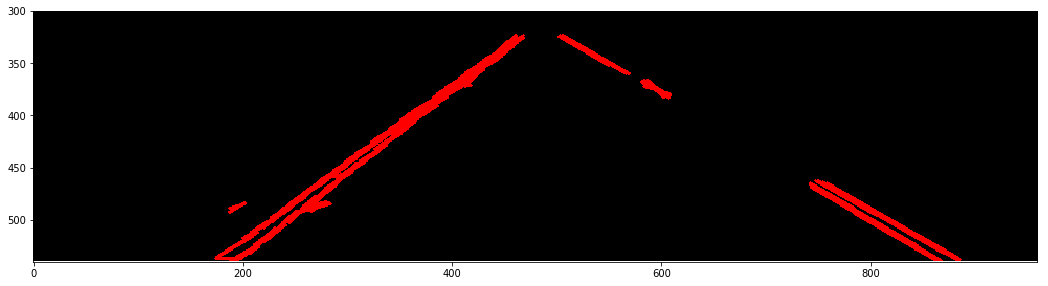

In [363]:
testLineSegments2('test_images/%s' % f, mask)

solidWhiteCurve.jpg


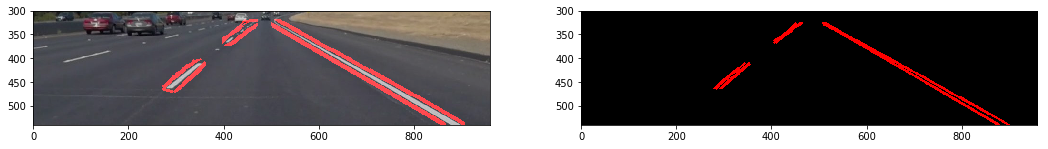

solidWhiteRight.jpg


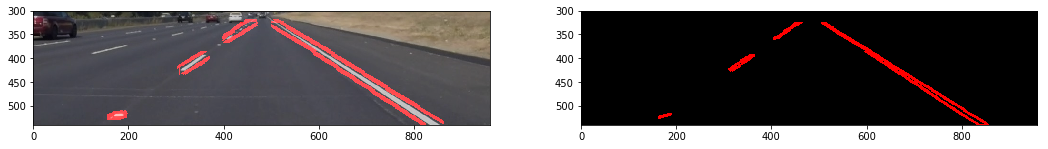

solidYellowCurve.jpg


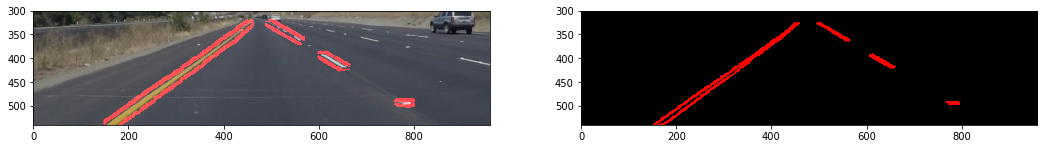

solidYellowCurve2.jpg


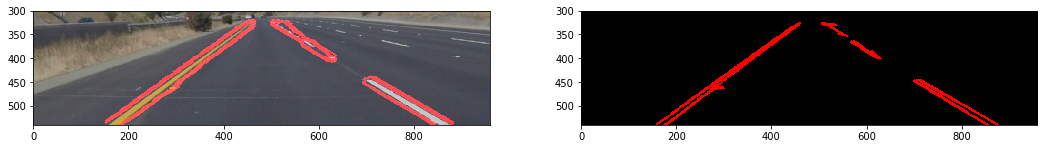

solidYellowLeft.jpg


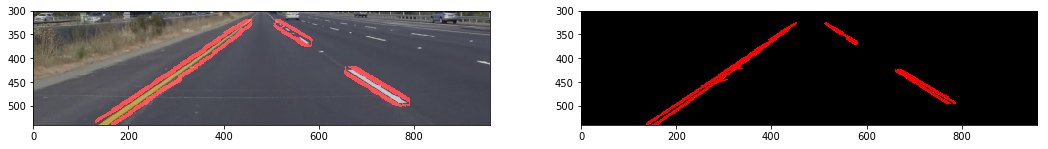

whiteCarLaneSwitch.jpg


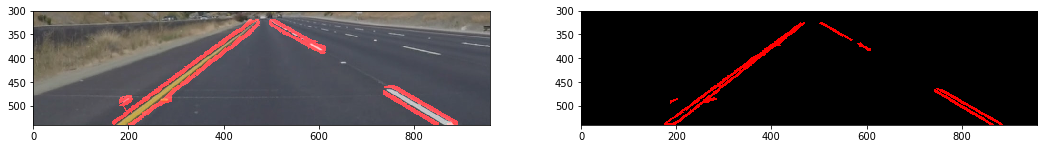

In [361]:
for f in os.listdir("test_images/"):
    print(f)
    testLineSegments2('test_images/%s' % f, mask)

#### Part 3: Connect/Draw complete lane lines

In [524]:
import pandas as pd
from sklearn import linear_model
import matplotlib as mplt

In [124]:
def testLinesRaw(path, mask):
    # First get the image
    image = mpimg.imread(path)
    
    # convert to grayscale and get canny edges
    gray_img = grayscale(image)
    canny_img = canny(gray_img, 10, 200)
    
    # next mask the image
    mask = np.array([[450, 325], [525, 325], [950, image.shape[0]], [100, image.shape[0]]], 'int32')
    masked_img = region_of_interest(canny_img, [mask])
    
    # gaussian blur:
    smooth_img = gaussian_blur(masked_img, 3)
    
    # detect line segments:
    lines = hough_output(smooth_img, 2, 15*np.pi/180, 25, 15, 10)
    
    return lines

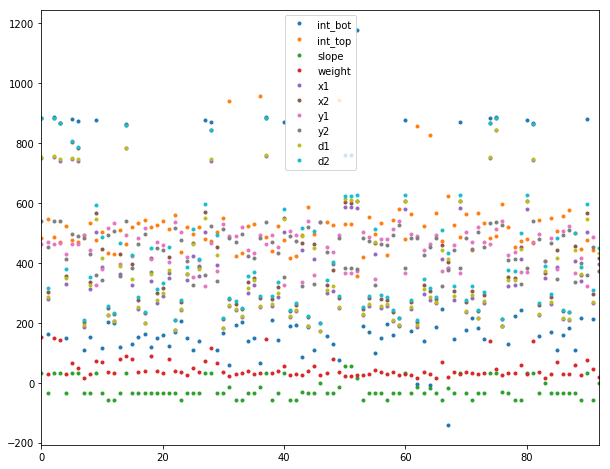

In [400]:
lines = testLinesRaw('test_images/whiteCarLaneSwitch.jpg', mask)


df_lines= describe_lines(lines)

df_lines['d1'] = (df_lines.x1**2 + (540-df_lines.y1)**2).apply(np.sqrt)
df_lines['d2'] = (df_lines.x2**2 + (540-df_lines.y2)**2).apply(np.sqrt)

df_lines.plot(lw=0, marker='.', figsize=(10,8))

In [401]:
df_lines.describe()

,int_bot,int_top,slope,weight,x1,x2,y1,y2,d1,d2
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,inf,-inf,-20.150538,47.309779,370.612903,410.709677,449.064516,442.720430,384.659829,426.600948
std,NaN,NaN,32.331821,32.374001,177.774285,198.114294,60.409797,65.260076,181.349407,199.057199
min,-141.000000,-inf,-57.000000,15.000000,174.000000,199.000000,324.000000,324.000000,174.025860,199.022612
25%,140.000000,473.000000,-34.000000,29.154759,247.000000,270.000000,405.000000,383.000000,251.872984,276.052531
50%,176.000000,508.000000,-34.000000,34.985711,308.000000,337.000000,464.000000,455.000000,324.766070,355.174605
75%,759.000000,539.000000,0.000000,56.938563,425.000000,467.000000,494.000000,492.000000,464.724650,513.281599
max,inf,957.000000,57.000000,153.182897,844.000000,885.000000,539.000000,539.000000,844.400379,885.002260


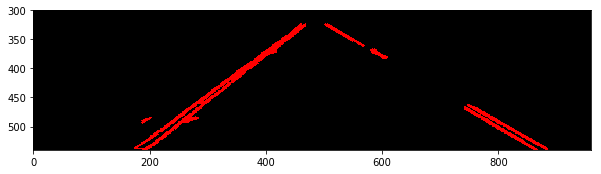

In [406]:
testLineSegments('test_images/whiteCarLaneSwitch.jpg', mask)

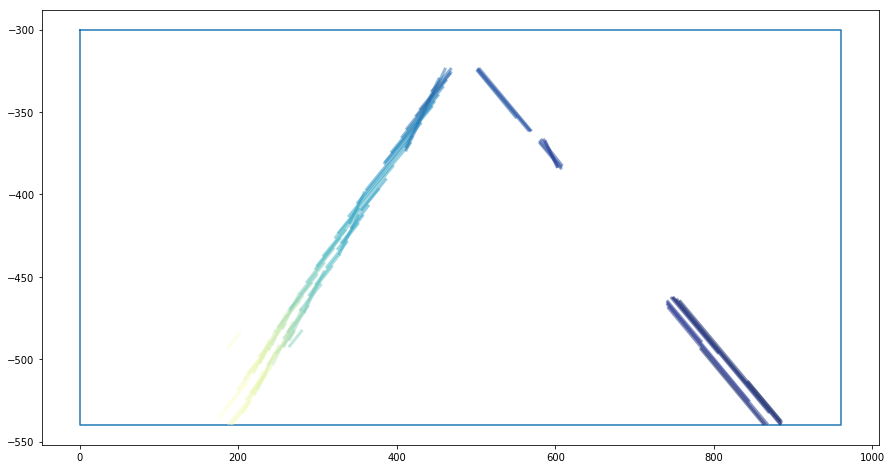

In [577]:
cmap = mplt.cm.get_cmap('YlGnBu')

candidates = df_lines[(df_lines.int_bot > 0) & (df_lines.int_bot < 960) &
                      (df_lines.int_top > 100) & (df_lines.int_top < 800)].sort_values('x1').reset_index(drop=True)
m = candidates.shape[0]

plt.figure(figsize=(15,8))
plt.plot([0, 960, 960, 0, 0], [-300, -300, -540, -540, -300] )
for i, row in candidates.iterrows():
    plt.plot([row['x1'], row['x2']], [-row['y1'], -row['y2']], alpha=0.5, color=cmap(i*1./m), lw=3)
#     plt.plot([row['int_top'], row['int_bot']], [-310, -540], alpha=0.1, color='b')

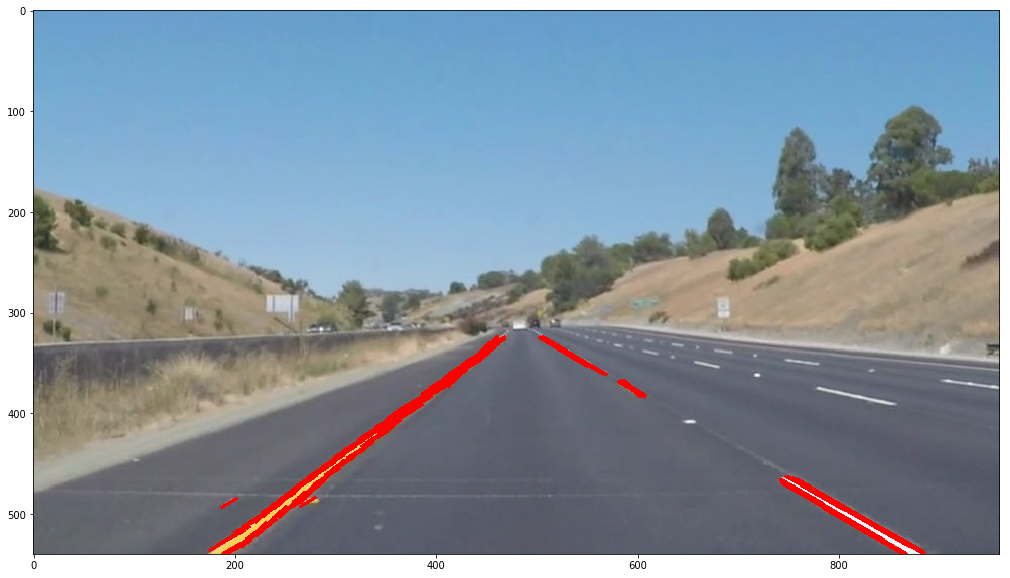

In [407]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
draw_lines(image, candidates[['x1', 'y1', 'x2', 'y2']].values.reshape((-1, 1, 4)), color=[255, 0, 0], thickness=2)
plt.figure(figsize=(20,10))
plt.imshow(image)

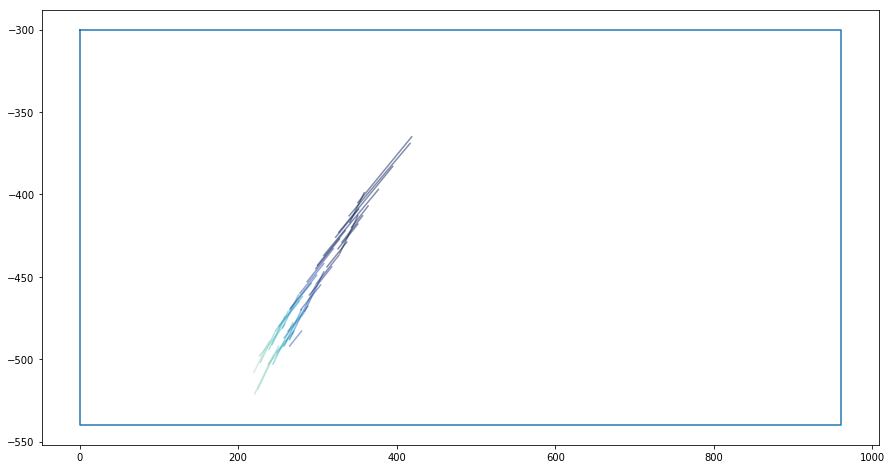

In [1316]:
# look at candidates with negative OR positive slope
left = candidates[candidates.slope < 0]
right = candidates[candidates.slope >= 0]

left['slope_roll'] = left.rolling(25, center=True).slope.mean()
left['int_top_roll'] = left.rolling(25, center=True).int_top.mean()
left['int_bot_roll'] = left.rolling(25, center=True).int_bot.mean()

test = left[left.slope_roll.notnull()]
m = test.shape[0] + 1

# plot extrapolated lines (with negative slope)
plt.figure(figsize=(15,8))
plt.plot([0, 960, 960, 0, 0], [-300, -300, -540, -540, -300] )
for i, row in test.iterrows():
    plt.plot([row['x1'], row['x2']], [-row['y1'], -row['y2']], alpha=0.5, color=cmap(i*1./m))
#     plt.plot([row['int_top'], row['int_bot']], [-310, -540], alpha=1, color=cmap(i*1./m))

(540, 300)

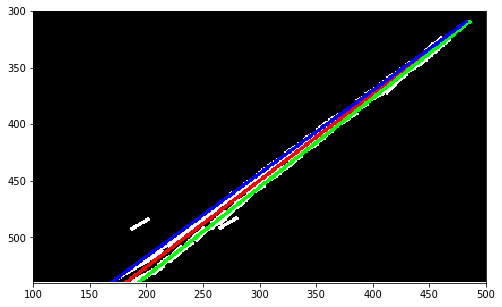

In [605]:
# extract and plot lines from left side of image (i.e. negative slope)
line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
draw_lines(line_img, left[['x1', 'y1', 'x2', 'y2']].values.reshape(-1, 1, 4),
           color=[255, 0, 0], thickness=2)

# c, h, v = cv2.findContours(grayscale(line_img), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
y_raw, x_raw, _ = np.where(line_img>200)
y_raw = y_raw.reshape(-1, 1)
x_raw = x_raw.reshape(-1, 1)
model = lm.fit(y_raw, x_raw)

y_line1 = np.array([[310], [540]])
x_line1 = model.predict(y_line1)

x_pred = model.predict(y_raw)
x_top = np.extract(x_raw >= x_pred, x_raw).reshape(-1, 1)
y_top = np.extract(x_raw >= x_pred, y_raw).reshape(-1, 1)
x_bot = np.extract(x_raw < x_pred, x_raw).reshape(-1, 1)
y_bot = np.extract(x_raw < x_pred, y_raw).reshape(-1, 1)

lm_top = linear_model.LinearRegression()
model_top = lm_top.fit(y_top, x_top)
y_lineTOP = np.array([[310], [540]])
x_lineTOP = model_top.predict(y_lineTOP)

lm_bot = linear_model.LinearRegression()
model_bot = lm_bot.fit(y_bot, x_bot)
y_lineBOT = np.array([[310], [540]])
x_lineBOT = model_bot.predict(y_lineBOT)


line_img2 = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
draw_lines(line_img2, left[['x1', 'y1', 'x2', 'y2']].values.reshape(-1, 1, 4),
           color=[255, 255, 255], thickness=2)
draw_lines(line_img2, np.array([int(x_line1[0]), y_line1[0], int(x_line1[1]), y_line1[1]]).reshape(-1, 1, 4),
           color=[255, 0, 0], thickness=2)
draw_lines(line_img2, np.array([int(x_lineTOP[0]), y_lineTOP[0], int(x_lineTOP[1]), y_lineTOP[1]]).reshape(-1, 1, 4),
           color=[0, 255, 0], thickness=2)
draw_lines(line_img2, np.array([int(x_lineBOT[0]), y_lineBOT[0], int(x_lineBOT[1]), y_lineBOT[1]]).reshape(-1, 1, 4),
           color=[0, 0, 255], thickness=2)

plt.figure(figsize=(10,5))
plt.imshow(line_img2)
plt.xlim([100, 500])
plt.ylim([540, 300])

(540, 300)

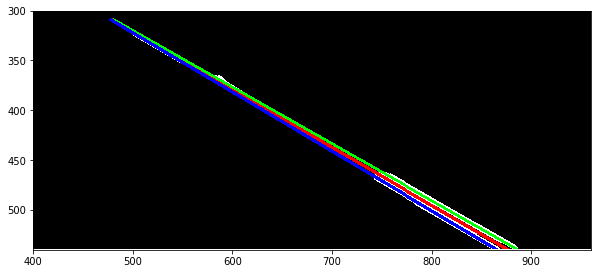

In [604]:
# extract and plot lines from right side of image (i.e. non-negative slope)
line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
draw_lines(line_img, right[['x1', 'y1', 'x2', 'y2']].values.reshape(-1, 1, 4),
           color=[255, 0, 0], thickness=2)

# c, h, v = cv2.findContours(grayscale(line_img), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
y_raw, x_raw, _ = np.where(line_img>200)
y_raw = y_raw.reshape(-1, 1)
x_raw = x_raw.reshape(-1, 1)

lm = linear_model.LinearRegression()
# # model = lm.fit(h[1][:, :, 1],h[1][:, :, 0])
# y_raw = np.vstack((h[0][:, :, 1], h[1][:, :, 1]))
# x_raw = np.vstack((h[0][:, :, 0], h[1][:, :, 0]))
model = lm.fit(y_raw, x_raw)

y_line1 = np.array([[310], [540]])
x_line1 = model.predict(y_line1)

x_pred = model.predict(y_raw)
x_top = np.extract(x_raw >= x_pred, x_raw).reshape(-1, 1)
y_top = np.extract(x_raw >= x_pred, y_raw).reshape(-1, 1)
x_bot = np.extract(x_raw < x_pred, x_raw).reshape(-1, 1)
y_bot = np.extract(x_raw < x_pred, y_raw).reshape(-1, 1)

lm_top = linear_model.LinearRegression()
model_top = lm_top.fit(y_top, x_top)
y_lineTOP = np.array([[310], [540]])
x_lineTOP = model_top.predict(y_lineTOP)

lm_bot = linear_model.LinearRegression()
model_bot = lm_bot.fit(y_bot, x_bot)
y_lineBOT = np.array([[310], [540]])
x_lineBOT = model_bot.predict(y_lineBOT)


line_img2 = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
draw_lines(line_img2, right[['x1', 'y1', 'x2', 'y2']].values.reshape(-1, 1, 4),
           color=[255, 255, 255], thickness=2)
draw_lines(line_img2, np.array([int(x_line1[0]), y_line1[0], int(x_line1[1]), y_line1[1]]).reshape(-1, 1, 4),
           color=[255, 0, 0], thickness=2)
draw_lines(line_img2, np.array([int(x_lineTOP[0]), y_lineTOP[0], int(x_lineTOP[1]), y_lineTOP[1]]).reshape(-1, 1, 4),
           color=[0, 255, 0], thickness=2)
draw_lines(line_img2, np.array([int(x_lineBOT[0]), y_lineBOT[0], int(x_lineBOT[1]), y_lineBOT[1]]).reshape(-1, 1, 4),
           color=[0, 0, 255], thickness=2)

plt.figure(figsize=(10,5))
plt.imshow(line_img2)
plt.xlim([400, 960])
plt.ylim([540, 300])

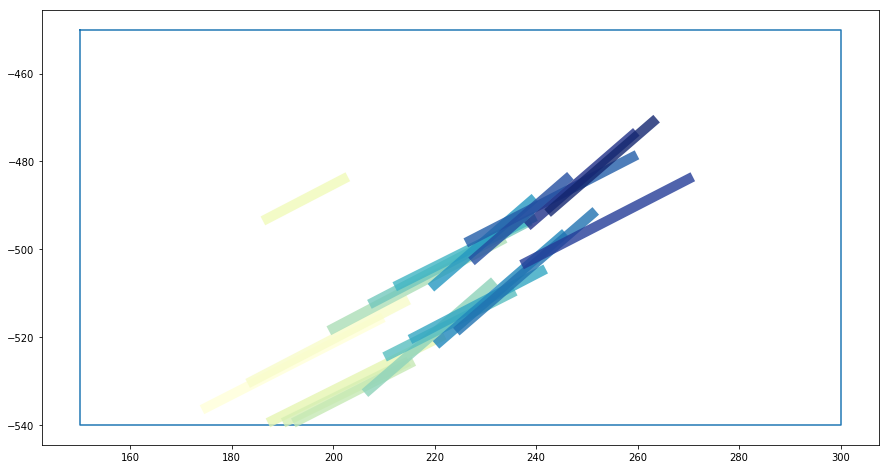

In [453]:
plt.figure(figsize=(15,8))
plt.plot([150, 300, 300, 150, 150], [-450, -450, -540, -540, -450] )
for i, row in candidates.head(20).iterrows():
    plt.plot([row['x1'], row['x2']], [-row['y1'], -row['y2']], alpha=0.8, color=cmap(i*1./20), lw=10)
#     plt.plot([row['int_top'], row['int_bot']], [-310, -540], alpha=0.1, color='b')

The below cells explore plotting the smoothed distribution of the y_intercepts (where each of the extrapolated line segments would intersect at the bottom and top of the image mask, respectively). The idea would be to identify the left and right peaks, and draw a line between them to estimate where the left and right lane lines are. However, I'm happy with the linear regression approach... so I didn't pursue this any further.

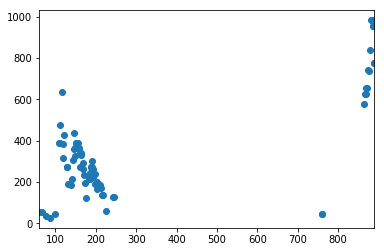

In [263]:
test = pd.DataFrame(index=np.arange(960))
test['interc'] = df_lines.groupby('int_bot').weight.sum()
test.interc.fillna(0, inplace=True)
# testrolling(2, min_periods=1).sum()
test[test.interc > 0]
test['rollinterc'] = test.interc.rolling(15, min_periods=1, center=True).sum()
test[test.interc > 0].rollinterc.plot(lw=0, marker='o')

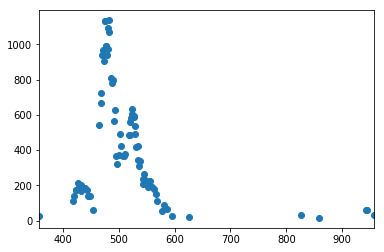

In [264]:
test = pd.DataFrame(index=np.arange(960))
test['interc'] = df_lines.groupby('int_top').weight.sum()
test.interc.fillna(0, inplace=True)
# testrolling(2, min_periods=1).sum()
test[test.interc > 0]
test['rollinterc'] = test.interc.rolling(15, min_periods=1, center=True).sum()
test[test.interc > 0].rollinterc.plot(lw=0, marker='o')

In [799]:
np.array([[450, 325], [525, 325], [950, image.shape[0]], [100, image.shape[0]]], 'int32')

array([[450, 325],
       [525, 325],
       [950, 540],
       [100, 540]], dtype=int32)

In [800]:
get_mask(image)

array([[450, 335],
       [525, 335],
       [950, 540],
       [100, 540]], dtype=int32)

In [977]:
# test pipeline
def testPipeline(path, mask):
    # First get the image
    image = mpimg.imread(path)
    
    # convert to grayscale and get canny edges
    gray_img = grayscale(image)
    canny_img = canny(gray_img, 10, 200)
    
    # next mask the image
    # mask = np.array([[450, 325], [525, 325], [950, image.shape[0]], [100, image.shape[0]]], 'int32')
    mask = get_mask(image)
    masked_img = region_of_interest(canny_img, [mask])
    
    mask_inner = get_mask(image, inner=True)
    masked_img = region_of_interest(masked_img, [mask_inner], invert=True)
    
    # gaussian blur:
    smooth_img = gaussian_blur(masked_img, 3)
    
    # detect line segments:
    line_seg = hough_lines2(smooth_img, 2, 15*np.pi/180, 25, 15, 10, style='avg')
    
    result = weighted_img(line_seg, image)
    result2 = region_of_interest(result, [mask])
    result3 = region_of_interest(result2, [mask_inner], invert=True)
    
#     plt.figure(figsize=(20,5))
#     plt.imshow(line_seg)
    plt.figure(figsize=(18,10))
    plt.subplot(1, 1, 1)
    plt.imshow(result3)
    plt.ylim([540, 300])
#     plt.subplot(1, 2, 2)
#     plt.imshow(line_seg)
#     plt.subplot(1, 3, 3)
#     plt.imshow(line_seg)
    plt.ylim([540, 300])
    plt.show()

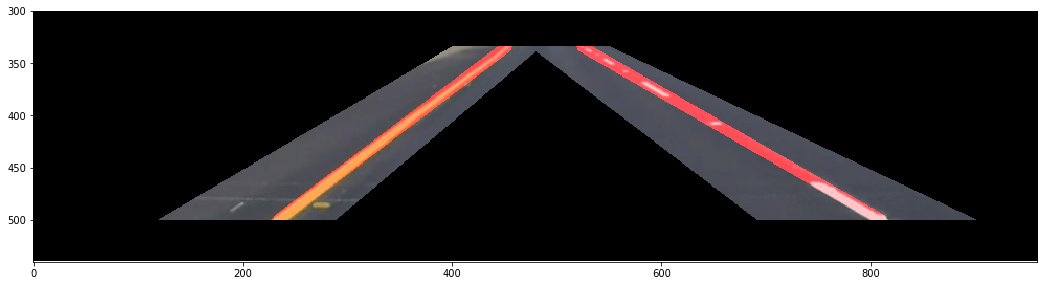

In [978]:
testPipeline('test_images/whiteCarLaneSwitch.jpg', mask)

#### Part 4: Color Filters

I want to highlight yellows and whites.

One hack is to convert to HSV space. *Then* convert to grayscale (as if it was stil a RGB image). This highlights the yellows/whites. 

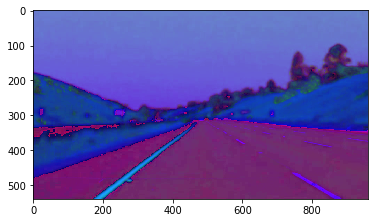

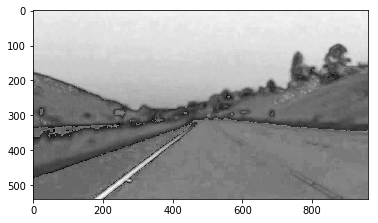

In [1063]:
# try converting hsv directly to grayscale
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
test = cv2.cvtColor(image, cv2.COLOR_RGB2HSV);
plt.imshow(test)
plt.show()
plt.imshow(grayscale(test), cmap='gray')

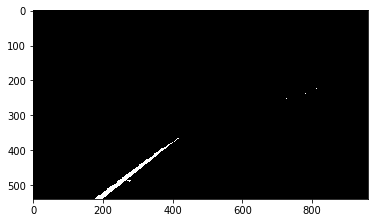

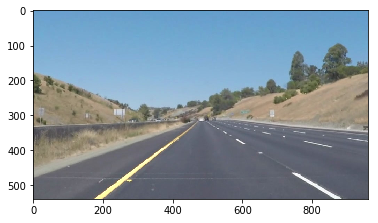

In [1073]:
# try highlighting yellows and superimposing on original image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

# convert to hsv
test = cv2.cvtColor(image, cv2.COLOR_RGB2HSV);

# threshold on yellows
test2 = cv2.inRange(test, np.array([20, 100, 100]), np.array([30, 255, 255]))
plt.imshow(test2, cmap='gray')

# superimpose yellow pixels (as a white mask) on top of original image
plt.show()
plt.imshow(weighted_img(cv2.cvtColor(test2, cv2.COLOR_GRAY2RGB), image, α=1, β=0.3))

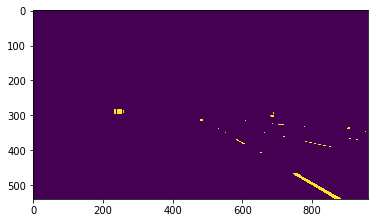

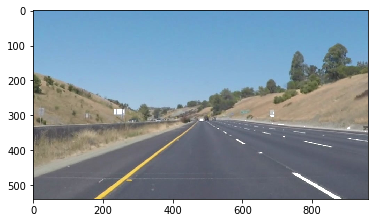

In [1184]:
def test_highlight_white(img):
    # convert to hls
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS);

    # threshold on whites
    mask_white = cv2.inRange(hls_img, np.array([0, 200, 0]), np.array([255, 255, 255]))

    # superimpose white pixels (as a white mask) on top of original image
    highlight_img = weighted_img(cv2.cvtColor(mask_white, cv2.COLOR_GRAY2RGB), image, α=1, β=0.3)
    
    return highlight_img, mask_white

# try highlighting yellows and superimposing on original image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

h, m = test_highlight_white(image)
plt.imshow(m)
plt.show()

# superimpose yellow pixels (as a white mask) on top of original image
plt.imshow(h)

In [1225]:
def highlight_yellow(img, target_img):
    # convert to hsv
#     hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS);

    # threshold on yellows
#     mask = cv2.inRange(hsv_img, np.array([20, 100, 100]), np.array([30, 255, 255]))
    mask = cv2.inRange(hls_img, np.array([20, 120, 80]), np.array([45, 200, 255]))
    
    mask_blur = gaussian_blur(mask, 5)

    # superimpose yellow pixels (as a white mask) on top of original image
    highlight_img = weighted_img(cv2.cvtColor(mask_blur, cv2.COLOR_GRAY2RGB), target_img, α=1, β=0.3)
    
    return highlight_img, mask, mask_blur

def highlight_white(img, target_img):
    # convert to hls
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS);

    # threshold on whites
    mask = cv2.inRange(hls_img, np.array([0, 200, 0]), np.array([255, 255, 255]))
    
    mask_blur = gaussian_blur(mask, 5)

    # superimpose white pixels (as a white mask) on top of original image
    highlight_img = weighted_img(cv2.cvtColor(mask_blur, cv2.COLOR_GRAY2RGB), target_img, α=1, β=0.3)
    
    return highlight_img, mask, mask_blur
    

In [1118]:
# test pipeline
def testPipelineHSV(path, mask):
    # First get the image
    image = mpimg.imread(path)
    
    # superimpose yellow pixels (as a white mask) on top of original image
    highlight_yell = highlight_yellow(image)
    # superimpose white pixels (as a white mask) on top of original image
    highlight_img = highlight_yellow(highlight_yell)
    
    # convert to grayscale and get canny edges
    gray_hsv = grayscale(highlight_img)
    canny_hsv = canny(gray_hsv, 10, 200)
    
    # convert to grayscale and get canny edges
    gray_orig = grayscale(image)
    canny_orig = canny(gray_orig, 10, 200)
    
    # combine hsv and regular canny edges
    canny_combo = cv2.bitwise_or(canny_hsv, canny_orig)
    
    # next mask the image
    mask = get_mask(image)
    masked_img = region_of_interest(canny_hsv, [mask])
    
    mask_inner = get_mask(image, inner=True)
    masked_img = region_of_interest(masked_img, [mask_inner], invert=True)
    
    # gaussian blur:
    smooth_img = gaussian_blur(masked_img, 3)
    
    # detect line segments:
    line_seg = hough_lines2(smooth_img, 2, 15*np.pi/180, 25, 15, 10, style='avg')
    
    result = weighted_img(line_seg, image)
    result2 = region_of_interest(result, [mask])
    result3 = region_of_interest(result2, [mask_inner], invert=True)
    
#     plt.figure(figsize=(20,5))
#     plt.imshow(line_seg)
    plt.figure(figsize=(18,5))
    plt.subplot(2, 3, 1)
    plt.imshow(canny_hsv)
    plt.ylim([540, 300])
    plt.subplot(2, 3, 2)
    plt.imshow(canny_orig)
    plt.ylim([540, 300])
#     plt.subplot(2, 3, 3)
#     plt.imshow(canny_combo)
#     plt.ylim([540, 300])
    plt.subplot(2, 3, 4)
    plt.imshow(masked_img)
    plt.ylim([540, 300])
    plt.subplot(2, 3, 5)
    plt.imshow(line_seg)
    plt.ylim([540, 300])
    plt.subplot(2, 3, 6)
    plt.imshow(result3)
    plt.ylim([540, 300])
    plt.show()

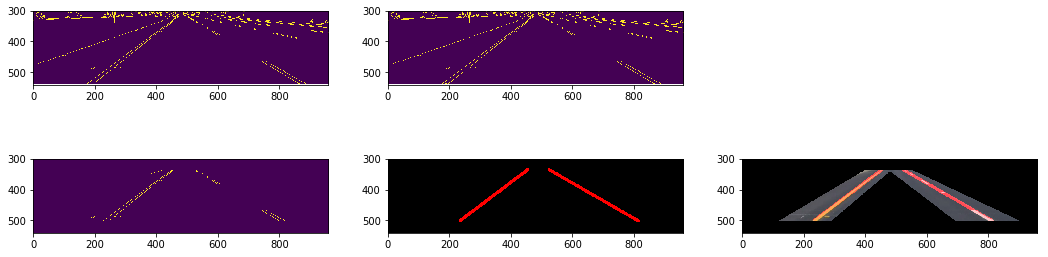

In [1119]:
testPipelineHSV('test_images/whiteCarLaneSwitch.jpg', mask)

In [ ]:
gray_img = grayscale(image)

In [1005]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [938]:
get_mask(image)

array([[400, 335],
       [550, 335],
       [950, 500],
       [100, 500]], dtype=int32)

In [1352]:
def double_mask(image):
    mask = get_mask(image)
    masked_out = region_of_interest(image, [mask])
    
    mask_inner = get_mask(image, inner=True)
    masked_img = region_of_interest(masked_out, [mask_inner], invert=True)
    
    return masked_img
    

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # superimpose yellow pixels (as a white mask) on top of original image
    highlight_yell, my, myb = highlight_yellow(image, image)
    # superimpose white pixels (as a white mask) on top of original image
    highlight_img, mw, mwb = highlight_white(image, highlight_yell)
    
    # just use yellow & white masks:
    wy_img = cv2.bitwise_or(myb, mwb)
    
    # # convert to grayscale and get canny edges
    gray_img0 = grayscale(image)
    canny_img0 = canny(gray_img0, 150, 300)
    
    canny_img = canny(wy_img, 10, 200)
    canny_img2 = canny(highlight_img, 150, 300)
    
    # next mask the image
    masked_img = double_mask(canny_img)
    
    # gaussian blur:
    smooth_img = gaussian_blur(masked_img, 5)
    
    smooth_img2 = gaussian_blur(double_mask(canny_img2), 5)
    
    # detect line segments:
    line_seg, left_raw, right_raw = hough_lines2(smooth_img, 2, 15*np.pi/180, 25, 15, 10, style='avg')

    result = weighted_img(line_seg, image)
#     draw_lines_final(result, left_raw, color=[0,0,255], style='fill')
#     draw_lines_final(result, right_raw, color=[0,0,255], style='fill')
#     result2 = double_mask(result)
    
#     plt.figure(figsize=(20,10));plt.imshow(canny_img); plt.show();#plt.ylim([520, 320]); plt.xlim([200,450]); plt.show()
#     plt.figure(figsize=(20,10));plt.imshow(smooth_img); plt.show();#plt.ylim([520, 320]); plt.xlim([200,450]); plt.show()
    
    return result#, smooth_img, smooth_img2

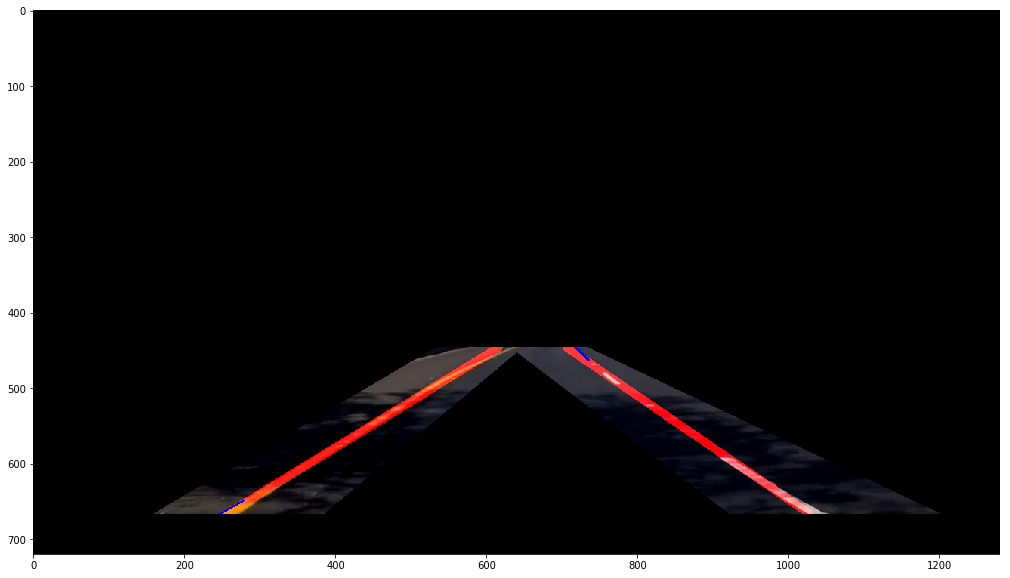

In [1348]:
# try highlighting yellows and superimposing on original image
image = mpimg.imread('test_video_images/Frame-12-10-2017-05-14-16.jpg')

out_img = process_image(image)
plt.figure(figsize=(20,10))
plt.imshow(out_img)
# plt.ylim([540, 300]); plt.xlim([200,850]);

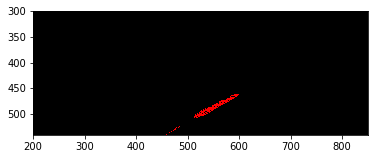

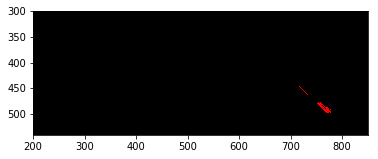

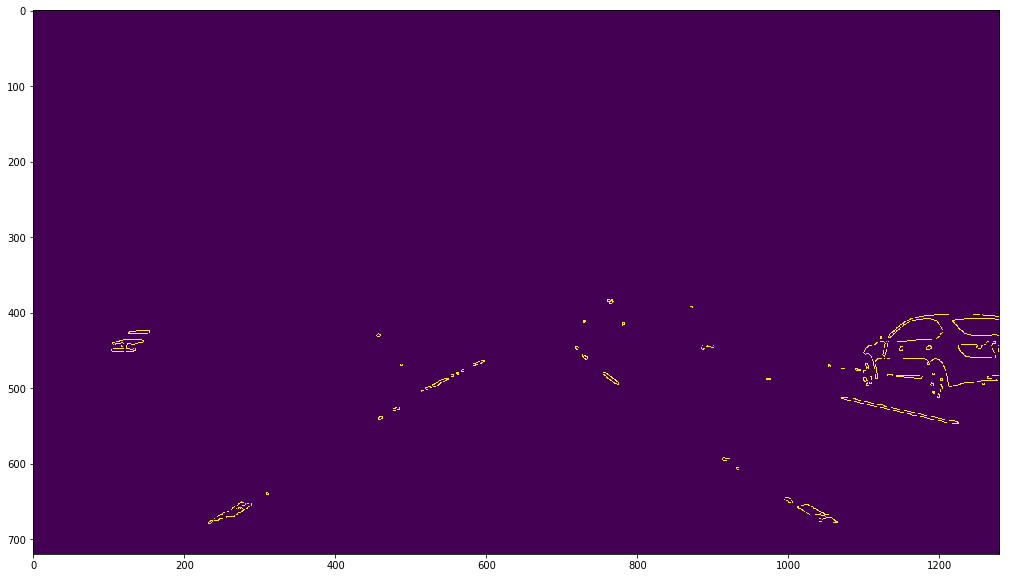

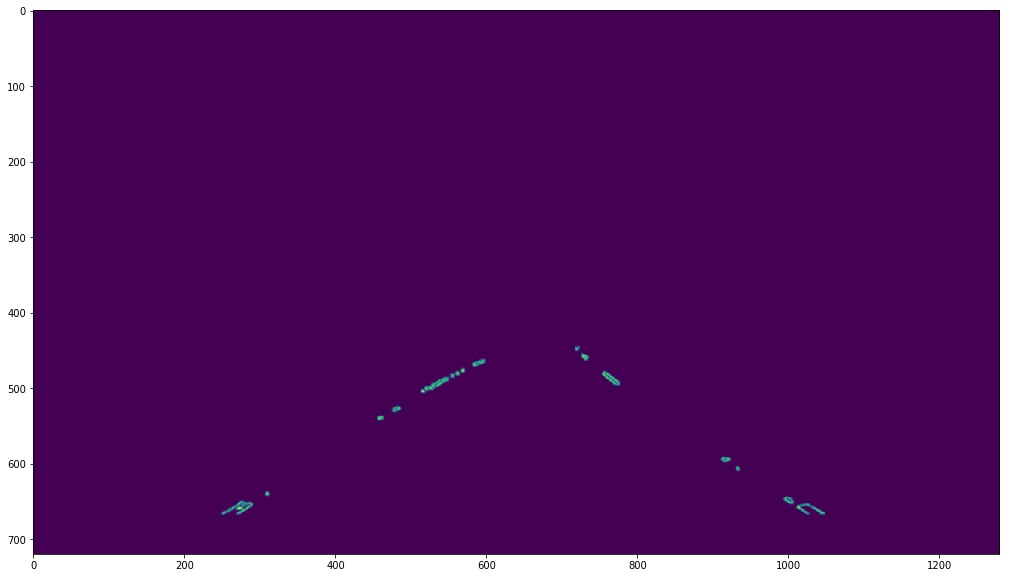

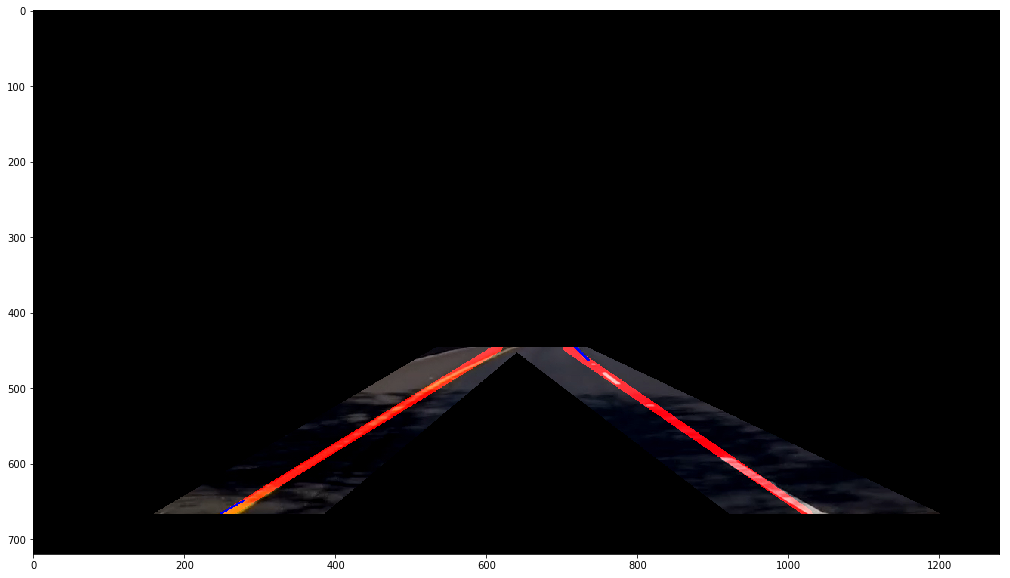

In [1340]:
# try highlighting yellows and superimposing on original image
image = mpimg.imread('test_video_images/Frame-12-10-2017-05-14-16.jpg')

out_img, smooth_img, smooth_img2 = process_image(image)
plt.figure(figsize=(20,10))
plt.imshow(out_img)
# plt.ylim([540, 300]); plt.xlim([200,850]);

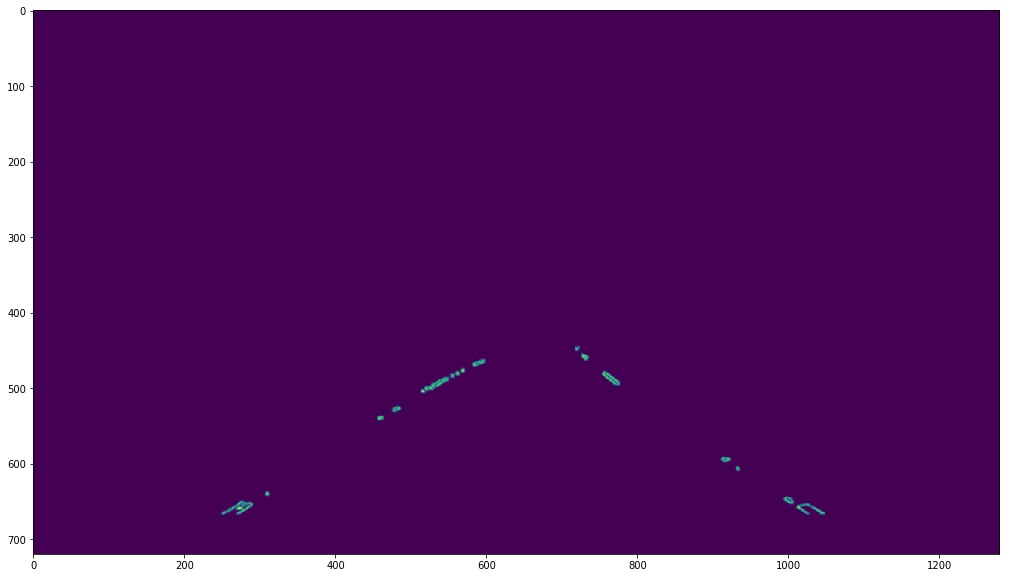

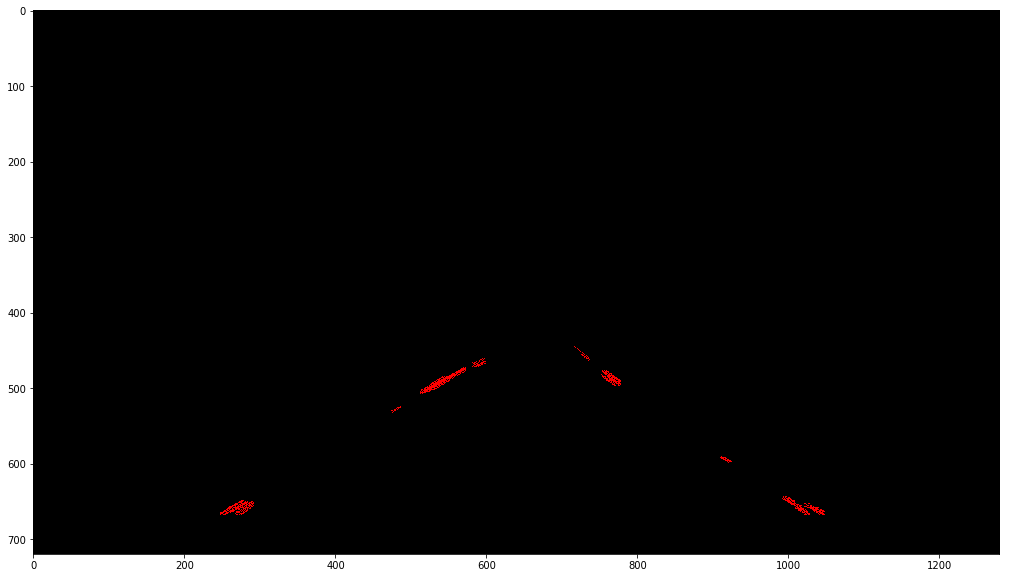

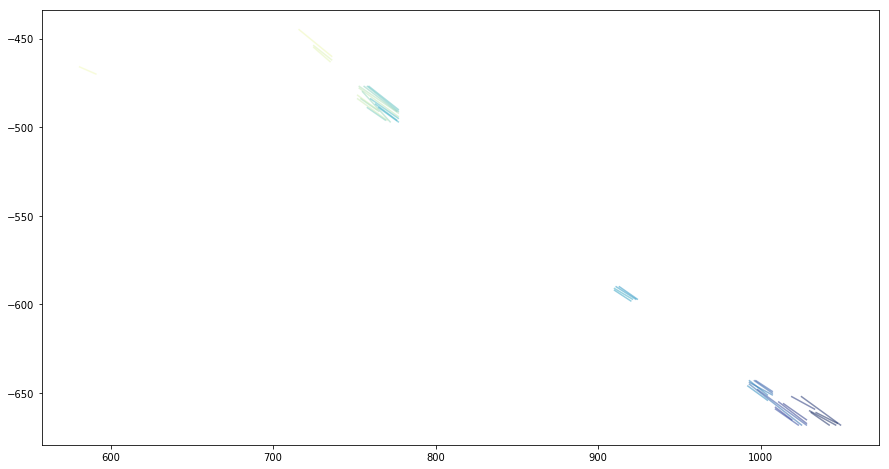

In [1341]:
img_test = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
lines_test = hough_output(smooth_img, 1, 3*np.pi/180, 25, 10, 2)
draw_lines(img_test, lines_test, thickness=1)

plt.figure(figsize=(20,10))
plt.imshow(smooth_img)
#plt.ylim([540, 300]); plt.xlim([200,850]); 
plt.show()


plt.figure(figsize=(20,10))
plt.imshow(img_test)
#plt.ylim([540, 300]); plt.xlim([200,850]); 
plt.show()

df_test = describe_lines(lines_test)
cand_test = filter_lines(df_test)

# look at candidates with negative OR positive slope
left_test = cand_test[cand_test.slope < 0]
right_test = cand_test[cand_test.slope >= 0]

m = right_test.shape[0] + 1

# plot extrapolated lines (with negative slope)
plt.figure(figsize=(15,8))
#plt.plot([0, 960, 960, 0, 0], [-300, -300, -540, -540, -300] )
for i, row in right_test.iterrows():
    plt.plot([row['x1'], row['x2']], [-row['y1'], -row['y2']], alpha=0.5, color=cmap(i*1./m))
#     plt.plot([row['int_top'], row['int_bot']], [-310, -540], alpha=1, color=cmap(i*1./m))
#plt.ylim([-540, -300]); plt.xlim([200,850]); plt.show()

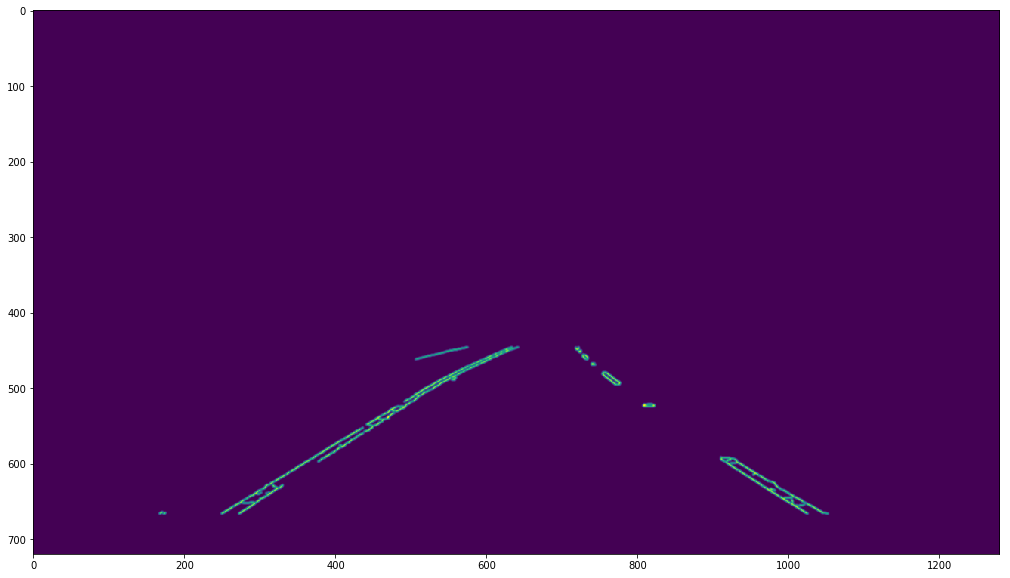

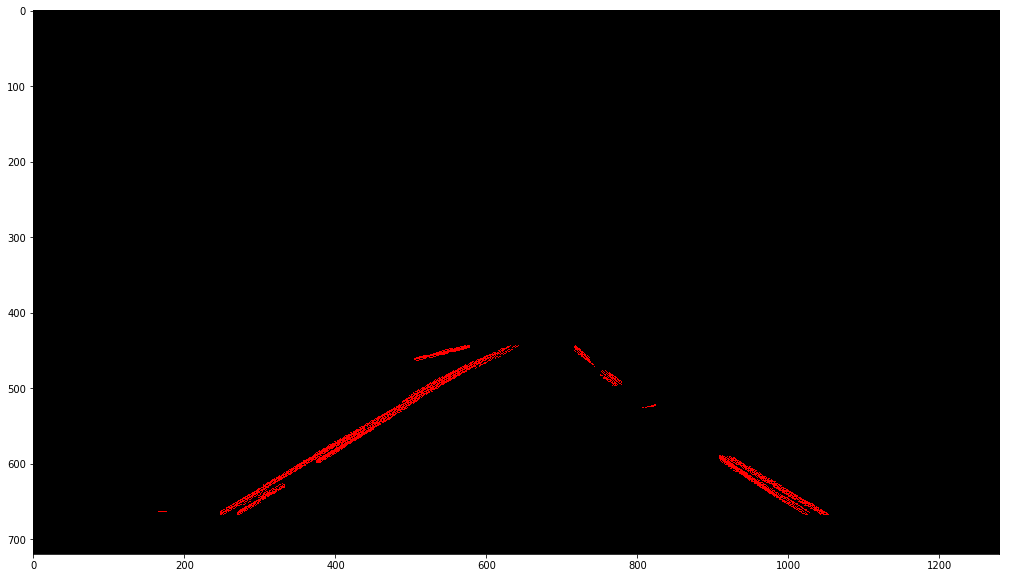

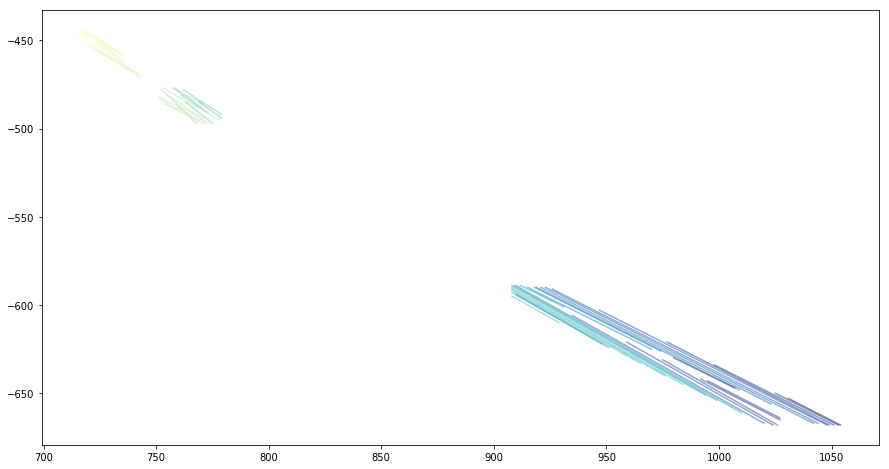

In [1343]:
img_test = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
lines_test = hough_output(smooth_img2, 1, 3*np.pi/180, 25, 10, 2)
draw_lines(img_test, lines_test, thickness=1)

plt.figure(figsize=(20,10))
plt.imshow(smooth_img2)
# plt.ylim([540, 300]); plt.xlim([200,850]); 
plt.show()


plt.figure(figsize=(20,10))
plt.imshow(img_test)
# plt.ylim([540, 300]); plt.xlim([200,850]); 
plt.show()

df_test = describe_lines(lines_test)
cand_test = filter_lines(df_test)

# look at candidates with negative OR positive slope
left_test = cand_test[cand_test.slope < 0]
right_test = cand_test[cand_test.slope >= 0]

m = right_test.shape[0] + 1

# plot extrapolated lines (with negative slope)
plt.figure(figsize=(15,8))
# plt.plot([0, 960, 960, 0, 0], [-300, -300, -540, -540, -300] )
for i, row in right_test.iterrows():
    plt.plot([row['x1'], row['x2']], [-row['y1'], -row['y2']], alpha=0.5, color=cmap(i*1./m))
#     plt.plot([row['int_top'], row['int_bot']], [-310, -540], alpha=1, color=cmap(i*1./m))
#plt.ylim([-540, -300]); plt.xlim([200,850]); plt.show()

Let's try the one with the solid white lane on the right first ...

In [1357]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time 
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 15.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [1358]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("examples/P1_example.mp4"))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [1355]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:41<00:00, 16.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 51.6 s, sys: 12.7 s, total: 1min 4s
Wall time: 42.2 s


In [1356]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [1353]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(5.5, 6.5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:22<00:00, 11.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 28.4 s, sys: 6.75 s, total: 35.2 s
Wall time: 23.1 s


In [1354]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))